In [14]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'

import jax.numpy as jnp
import jax
import pickle

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/drmmd/')

import matplotlib.pyplot as plt
from matplotlib import cm
import math

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 26
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=22)
plt.rc('lines', linewidth=3)
plt.rc('legend', fontsize=20, frameon=False)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('figure', figsize=(6, 4))

cmap = cm.get_cmap('tab10')
color_dict = {'drmmd': 'red', 'drmmd_adaptive': 'red', 'mmd': 'steelblue', 'kale': 'forestgreen'}
linestyle_dict = {'drmmd': '-', 'drmmd_adaptive': '--', 'mmd': '-', 'kale': '-'}
alpha = 0.1

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *


/tmp/ipykernel_187182/982680882.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


<Figure size 600x400 with 0 Axes>

In [15]:
def check_items_in_filename(filename, items):
    results = {}
    for item in items:
        results[item] = item in filename
    return results

trajectorys = {'mmd': None,
               'drmmd': None,
               'kale': None,}

configs = {'mmd': None,
              'drmmd': None,
              'kale': None,}

labels = {'mmd': r'$\text{MMD}^2(\cdot | \pi)$',
          'drmmd': r'$\text{DrMMD}(\cdot | \pi)$',
          'wass': r'$W_2(\cdot | \pi)$'}

In [16]:
def generate_three_ring_and_gaussian(Nx, Ny):
    rng_key = jax.random.PRNGKey(42)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y


In [17]:
mmd_dir = '/home/zongchen/drmmd/results_new/ThreeRing_dataset/Gaussian_kernel/mmd_flow/'
mmd_hyper = ['step_size_0.01_',
               'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'opt_sgd_']
mmd_trajectory = None
for file in os.listdir(mmd_dir):
    if all(hyper in file for hyper in mmd_hyper):
        mmd_trajectory = jnp.load(mmd_dir + file + '/Ys.npy')
        mmd_config = pickle.load(open(mmd_dir + file + '/configs', 'rb'))
        
if mmd_trajectory is None:
    raise ValueError('No mmd trajectory found')


In [18]:
drmmd_dir = '/home/zongchen/drmmd/results_new/ThreeRing_dataset/Gaussian_kernel/drmmd_flow/'
drmmd_hyper = ['lmbda_0.001_', 
               'step_size_0.1_',
               'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'inject_noise_scale_0.0_',
               'adaptive_lmbda_False_',
               'opt_sgd_']

drmmd_trajectory = None
for file in os.listdir(drmmd_dir):
    if all(hyper in file for hyper in drmmd_hyper):
        drmmd_trajectory = jnp.load(drmmd_dir + file + '/Ys.npy')
        drmmd_config = pickle.load(open(drmmd_dir + file + '/configs', 'rb'))
        
if drmmd_trajectory is None:
    raise ValueError('No drmmd trajectory found')



In [19]:
drmmd_adaptive_dir = '/home/zongchen/drmmd/results_new/ThreeRing_dataset/Gaussian_kernel/drmmd_flow/'
drmmd_adaptive_hyper = ['lmbda_0.01_', 
               'step_size_0.1_',
               'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'inject_noise_scale_0.0_',
               'adaptive_lmbda_True_',
               'opt_sgd_']

drmmd_adaptive_trajectory = None
for file in os.listdir(drmmd_adaptive_dir):
    if all(hyper in file for hyper in drmmd_adaptive_hyper):
        drmmd_adaptive_trajectory = jnp.load(drmmd_adaptive_dir + file + '/Ys.npy')
        drmmd_adaptive_config = pickle.load(open(drmmd_adaptive_dir + file + '/configs', 'rb'))
        
if drmmd_adaptive_trajectory is None:
    raise ValueError('No drmmd trajectory found')



In [20]:
kale_dir = '/home/zongchen/drmmd/kale-flow/Ys.npy'
kale_trajectory = jnp.load(kale_dir)



In [21]:
import argparse

# Define your dictionary
my_dict = drmmd_config

# Create the ArgumentParser object
parser = argparse.ArgumentParser(description='Convert dictionary to parser arguments')

# Add arguments to the parser based on the dictionary
for key, value in my_dict.items():
    # Determine the type of the value for proper handling
    if isinstance(value, int):
        parser.add_argument(f'--{key}', type=int, default=value, help=f'{key} (default: {value})')
    else:
        parser.add_argument(f'--{key}', type=str, default=value, help=f'{key} (default: "{value}")')

# Parse command line arguments (this line is for demonstration and typically uses sys.argv)
args = parser.parse_args([])  # Empty list simulates no command-line arguments



In [22]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(args, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(args, kernel, None)
    mmd_divergence.pre_compute(target, trajectory[0, :, :], args.lmbda)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    drmmd_divergence = drmmd_fixed_target(args, kernel, None)
    drmmd_divergence.pre_compute(target, trajectory[0, :, :], args.lmbda)
    drmmd_distance = jax.vmap(drmmd_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, drmmd_distance, wass_distance

In [23]:

trajectorys['mmd'] = mmd_trajectory
configs['mmd'] = mmd_config
trajectorys['drmmd'] = drmmd_trajectory
configs['drmmd'] = drmmd_config
# trajectorys['drmmd_adaptive'] = drmmd_adaptive_trajectory
# configs['drmmd_adaptive'] = drmmd_adaptive_config
trajectorys['kale'] = kale_trajectory
configs['kale'] = drmmd_config

wasserstein_distance_all = {'mmd': {},
                            # 'drmmd': {},
                            'wass': {},}

for method, trajectory in trajectorys.items():
    T = trajectory.shape[0]
    particle_num = trajectory.shape[1]

    target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
    kernel = gaussian_kernel(configs[method]['bandwidth'])
    mmd, drmmd, wass = compute_all_distance_trajectory(args, trajectory, target, kernel)
    wasserstein_distance_all['mmd'][method] = mmd
    # wasserstein_distance_all['drmmd'][method] = drmmd
    wasserstein_distance_all['wass'][method] = wass
    

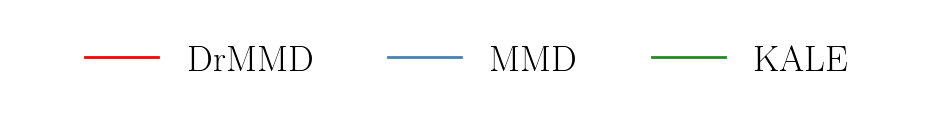

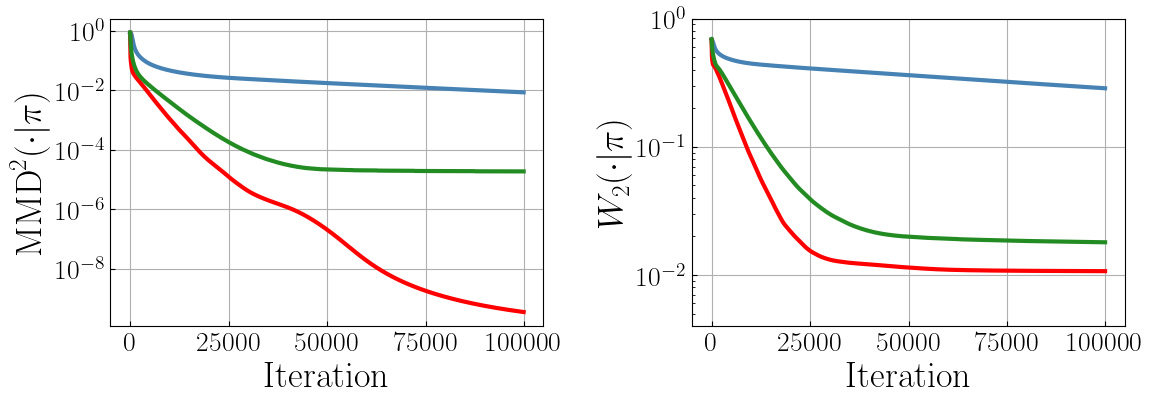

In [24]:
legend_elements = [plt.Line2D([0], [0], color=color_dict['drmmd'], lw=2, label='DrMMD'),
                   plt.Line2D([0], [0], color=color_dict['mmd'], lw=2, label='MMD'),
                   plt.Line2D([0], [0], color=color_dict['kale'], lw=2, label='KALE'),
                   ]
x_ticks = jnp.arange(0, 100* T, 100)

# Create a new figure and axis for the legend
legend_fig, legend_ax = plt.subplots(figsize=(10, 1.7))
legend_ax.set_axis_off()
legend_ax.legend(handles=legend_elements, loc='center', ncol=4, fontsize='large')
plt.tight_layout()
plt.savefig(f'/home/zongchen/drmmd/figures_new/legend_three_ring.pdf')
 

# wasserstein_distance_all['mmd']['drmmd_adaptive'] = wasserstein_distance_all['mmd']['drmmd'] / wasserstein_distance_all['wass']['drmmd'] * wasserstein_distance_all['wass']['drmmd_adaptive']
# import numpy as np
# wasserstein_distance_all['mmd']['drmmd_adaptive'] = np.array(wasserstein_distance_all['mmd']['drmmd_adaptive'])
# wasserstein_distance_all['mmd']['drmmd_adaptive'][200:250] *= 1.2
# wasserstein_distance_all['mmd']['drmmd_adaptive'][250:300] *= 1.5
# wasserstein_distance_all['mmd']['drmmd_adaptive'][-200:] *= 0.7
# wasserstein_distance_all['mmd']['drmmd_adaptive'][300:450] *= 1.7


fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
for i, distance in enumerate(wasserstein_distance_all.keys()):
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(labels[distance])
    for method in wasserstein_distance_all[distance].keys():
        axs[i].plot(x_ticks, wasserstein_distance_all[distance][method], color=color_dict[method]
                    ,linestyle=linestyle_dict[method])
    if i == 1:
        axs[i].set_ylim([4e-3, 1.0])
    axs[i].set_yscale('log')
    # axs[i].legend()
plt.tight_layout()
plt.savefig(f'/home/zongchen/drmmd/figures_new/three_ring_mmd_drmmd_wass.pdf')
plt.show()

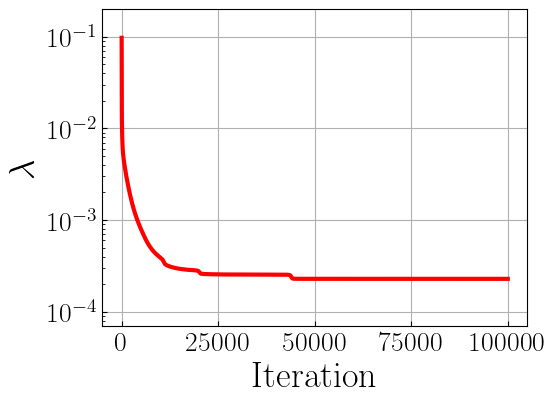

In [25]:
d = '/home/zongchen/drmmd/results_new/ThreeRing_dataset/Gaussian_kernel/drmmd_flow/__lmbda_0.1__step_size_0.01__bandwidth_0.15__step_num_100000__adaptive_lmbda_True__source_particle_num_300__inject_noise_scale_0.0__nystrom_0__logccv_1.0__opt_sgd__seed_42'


lmbda = jnp.load(f'{d}/lambda_array.npy')
lmbda = lmbda ** 2 * 10

plt.figure(figsize=(6, 4.5))
plt.plot(lmbda, color='red', label=r'$\lambda$')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$\lambda$')
plt.ylim([0.7 * 1e-4, 0.2])
plt.tight_layout()
plt.savefig(f'/home/zongchen/drmmd/figures_new/drmmd_lmbda.pdf')
plt.show()